In [1]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
#import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import plotly.graph_objects as go
import plotly.express as px
import random
import zipfile
from PIL import Image
from tensorflow.keras.optimizers import SGD

/home/mattmori/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-29 11:44:47.522781: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 11:44:47.583997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 11:44:47.584043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 11:44:47.588951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

Define Data Path and Data Set Name

In [2]:
# REPLACE NAMES
train_data_dir = '/Master Folder/train'
valid_data_dir = 'pet_images/Master Folder/valid'
test_data_dir = 'pet_images/Master Folder/test'

#'/mnt/c/Users/mattm/OneDrive/Documents/ecs111/ecs111_project_pet_emotions_repo/ecs111

data_dir = 'pet_images'


ds_name = 'Pets Facial Expression'


In [3]:
# Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        if fold == 'Master Folder':
            continue
            
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [4]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)
df.head()


filepaths labels
0  pet_images/Angry/02.jpg  Angry
1  pet_images/Angry/03.jpg  Angry
2  pet_images/Angry/04.jpg  Angry
3  pet_images/Angry/05.jpg  Angry
4  pet_images/Angry/06.jpg  Angry

In [5]:
print(df['labels'].value_counts())
counts = df['labels'].value_counts()

Other    256
Angry    250
happy    250
Sad      250
Name: labels, dtype: int64


In [6]:
def analyze_dataset(df, name='df'):
    num_images = df.shape[0]
    num_classes = len(df['labels'].unique())
    
    print(f"The {name} dataset has {num_images} images.")
    print(f"The {name} dataset has {num_classes} classes.")
    
    print(f"The {name} dataset has:")
    print("=" * 70)
    print()
    
    for label, group in df.groupby('labels'):
        num_class = len(group)
        print(f"Class '{label}' has {num_class} images")
        print('-' * 70)

# Example Usage
# Assuming df and ds_name are defined
analyze_dataset(df, ds_name)

The Pets Facial Expression dataset has 1006 images.
The Pets Facial Expression dataset has 4 classes.
The Pets Facial Expression dataset has:

Class 'Angry' has 250 images
----------------------------------------------------------------------
Class 'Other' has 256 images
----------------------------------------------------------------------
Class 'Sad' has 250 images
----------------------------------------------------------------------
Class 'happy' has 250 images
----------------------------------------------------------------------


In [70]:
filepaths[1:10]

['pet_images/Angry/03.jpg',
 'pet_images/Angry/04.jpg',
 'pet_images/Angry/05.jpg',
 'pet_images/Angry/06.jpg',
 'pet_images/Angry/08.jpg',
 'pet_images/Angry/09.jpg',
 'pet_images/Angry/10.jpg',
 'pet_images/Angry/12.jpg',
 'pet_images/Angry/16.jpg']

Define Data Path and Data Set Name

In [8]:
def check_null_values(df, name='df'):
    
    num_null_vals = sum(df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"The {name} dataset has no null values")
    
    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        

check_null_values(df, ds_name)

The Pets Facial Expression dataset has no null values


Spliting the dataframe into train, valid, and test

In [9]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)


In [10]:
analyze_dataset(train_df, "Training "+ds_name)
analyze_dataset(valid_df, "Validation "+ds_name)
analyze_dataset(test_df, "Testing "+ds_name)

The Training Pets Facial Expression dataset has 804 images.
The Training Pets Facial Expression dataset has 4 classes.
The Training Pets Facial Expression dataset has:

Class 'Angry' has 194 images
----------------------------------------------------------------------
Class 'Other' has 217 images
----------------------------------------------------------------------
Class 'Sad' has 193 images
----------------------------------------------------------------------
Class 'happy' has 200 images
----------------------------------------------------------------------
The Validation Pets Facial Expression dataset has 121 images.
The Validation Pets Facial Expression dataset has 4 classes.
The Validation Pets Facial Expression dataset has:

Class 'Angry' has 32 images
----------------------------------------------------------------------
Class 'Other' has 24 images
----------------------------------------------------------------------
Class 'Sad' has 31 images
----------------------------------

Create Image Data Generator

In [11]:
# crobed image size
batch_size = 24
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 804 validated image filenames belonging to 4 classes.
Found 121 validated image filenames belonging to 4 classes.
Found 81 validated image filenames belonging to 4 classes.


Visualizing the Data Set

In [12]:
fig = go.Figure(go.Bar(
            x= counts.values,
            y=counts.index,
            orientation='h'))

fig.update_layout(title='Data Distribution in Bars',font_size=15,title_x=0.45)

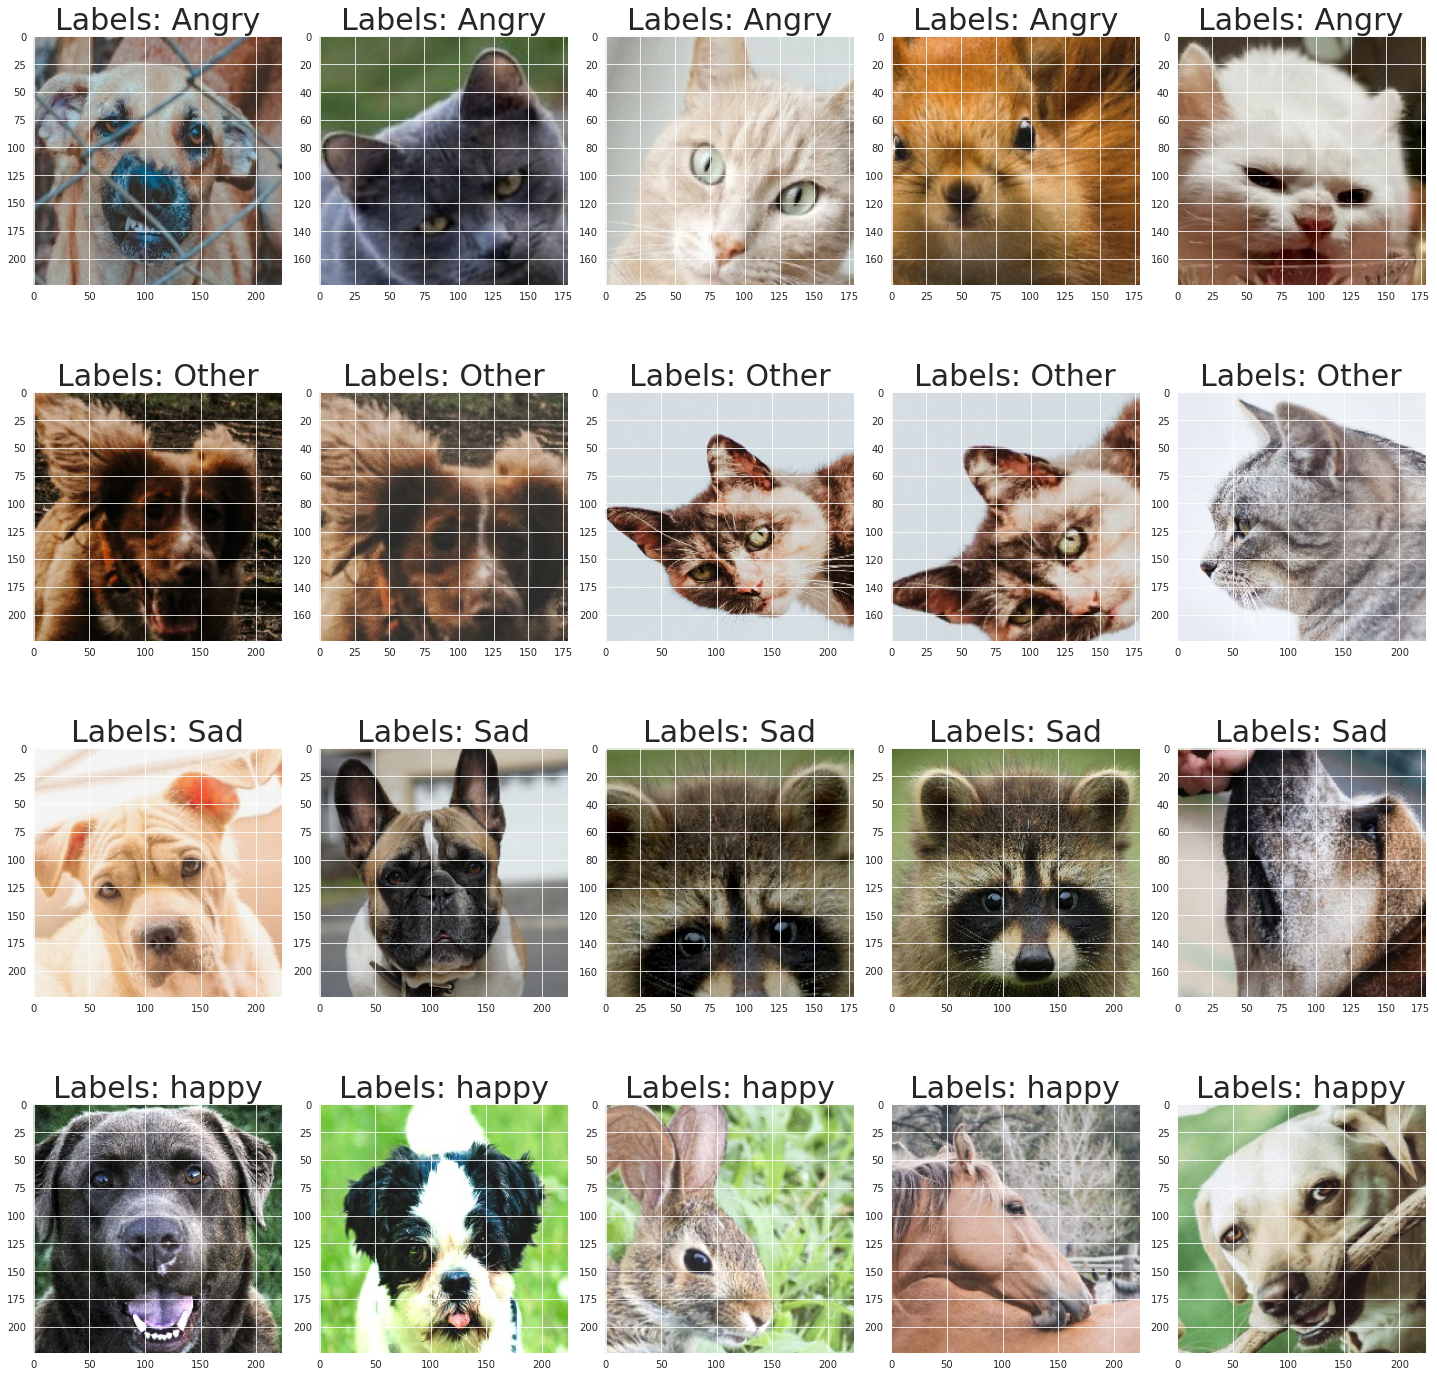

In [13]:

grouped_data = df.groupby("labels")

num_images_per_category = 5

fig, axes = plt.subplots(len(grouped_data), num_images_per_category, figsize=(20, 20))

for i, (category, group) in enumerate(grouped_data):
  
    random_indices = random.sample(range(len(group)), num_images_per_category)

    for j, index in enumerate(random_indices):
        filename = group.iloc[index]["filepaths"]
        label = group.iloc[index]["labels"]
        #image_path = os.path.join(image_dir, filename)
        image_path = os.path.join(filename)
        image = Image.open(image_path)

        axes[i, j].imshow(image)
        axes[i, j].set_title("Labels: " + label, fontsize = 30)
        

plt.tight_layout()
plt.show()

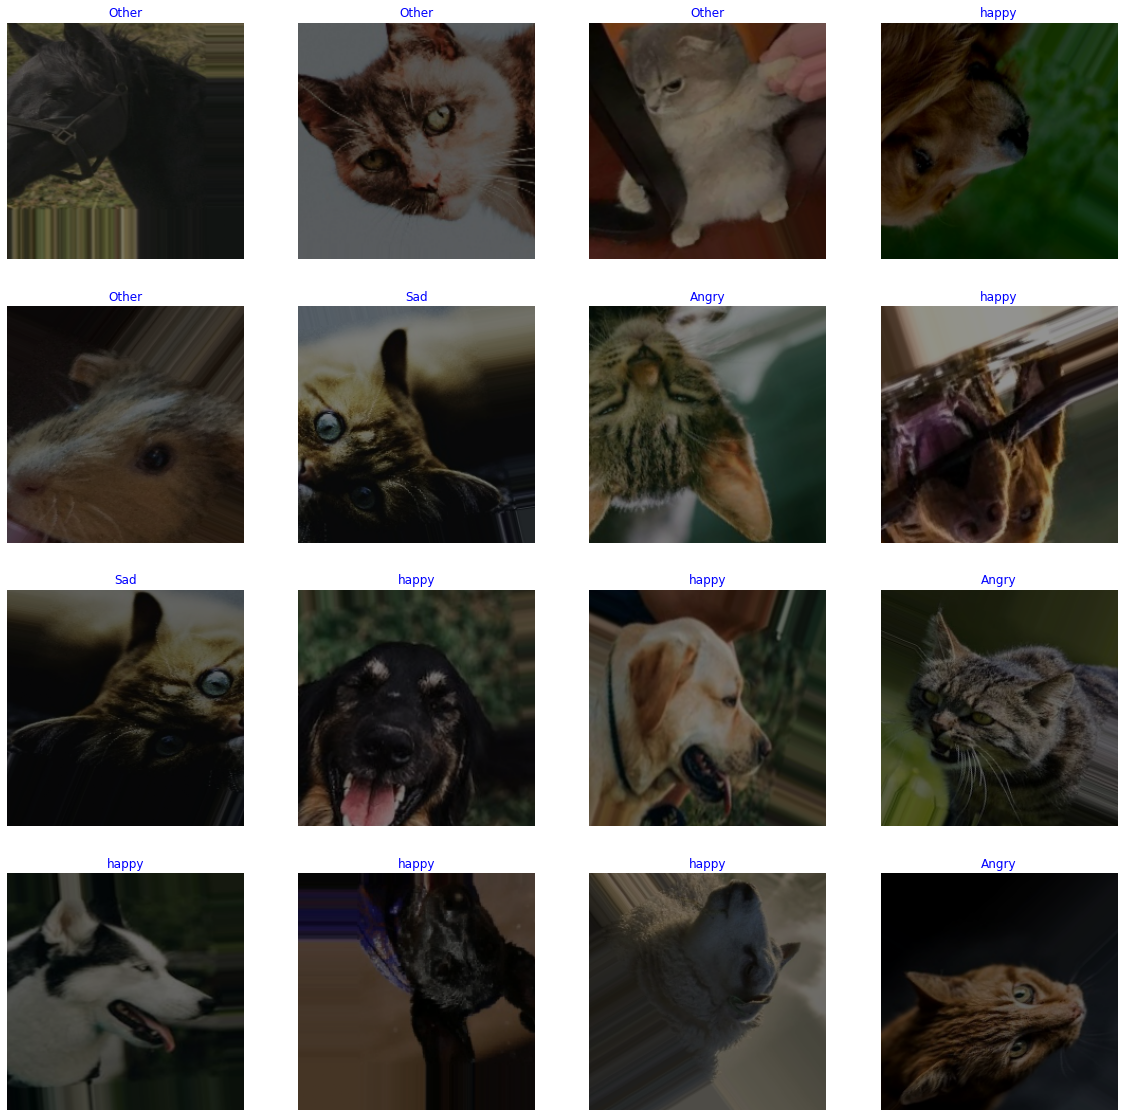

In [14]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    
plt.show()


Creating the Plot

In [15]:
img_size = (300, 300) #change to 300
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", drop_connect_rate = 0.55, input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, activation='relu'),
    Dense(128,  activation= 'relu'),
   #Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

#kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
               #bias_regularizer= regularizers.l1(0.006),
model.summary()

2024-02-29 11:44:58.424492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:3b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-29 11:44:58.425048: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 11216563 (42.79 MB)
Trainable params: 4299

Compiling the Model

In [16]:
# Set the training parameters
model.compile(optimizer = SGD(learning_rate=0.1), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Training the Model

In [17]:


STEP_SIZE_TRAIN=train_gen.n // train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n  // valid_gen.batch_size

import time
start_time = time.time()
batch_size = 16   # set batch size for training
history = model.fit(x=train_gen,
                    epochs= 100,
                    verbose= 1,
                    steps_per_epoch =STEP_SIZE_TRAIN,
                    validation_data= valid_gen, 
                    validation_steps= STEP_SIZE_VALID,
                    shuffle= False)

print("My program took", time.time() - start_time, "to run")

#b3 w batch size 16= 503 seconds
#b3 w batch size 24= 580 seconds

#bw 2 batch size 16, sgd(.1) and im_size 300=667 seconds
#633
#580



Epoch 1/100
33/33 [==============================] - 66s 2s/step - loss: 1.4062 - accuracy: 0.3965 - val_loss: 1.1829 - val_accuracy: 0.4583
Epoch 2/100
33/33 [==============================] - 56s 2s/step - loss: 1.1702 - accuracy: 0.4836 - val_loss: 1.1266 - val_accuracy: 0.5667
Epoch 3/100
33/33 [==============================] - 54s 2s/step - loss: 1.0968 - accuracy: 0.5354 - val_loss: 0.9568 - val_accuracy: 0.5750
Epoch 4/100
33/33 [==============================] - 53s 2s/step - loss: 1.0062 - accuracy: 0.6023 - val_loss: 0.8539 - val_accuracy: 0.6917
Epoch 5/100
33/33 [==============================] - 57s 2s/step - loss: 0.9484 - accuracy: 0.6098 - val_loss: 0.8696 - val_accuracy: 0.6583
Epoch 6/100
33/33 [==============================] - 54s 2s/step - loss: 0.8945 - accuracy: 0.6402 - val_loss: 0.8730 - val_accuracy: 0.6500
Epoch 7/100
33/33 [==============================] - 55s 2s/step - loss: 0.8271 - accuracy: 0.6705 - val_loss: 0.7166 - val_accuracy: 0.6833
Epoch 8/100
3

Epoch 59/100
33/33 [==============================] - 55s 2s/step - loss: 0.2830 - accuracy: 0.8965 - val_loss: 0.3035 - val_accuracy: 0.9083
Epoch 60/100
33/33 [==============================] - 54s 2s/step - loss: 0.2231 - accuracy: 0.9268 - val_loss: 0.3171 - val_accuracy: 0.9000
Epoch 61/100
33/33 [==============================] - 56s 2s/step - loss: 0.2187 - accuracy: 0.9205 - val_loss: 0.3081 - val_accuracy: 0.9167
Epoch 62/100
33/33 [==============================] - 57s 2s/step - loss: 0.1814 - accuracy: 0.9293 - val_loss: 0.2228 - val_accuracy: 0.9417
Epoch 63/100
33/33 [==============================] - 53s 2s/step - loss: 0.2438 - accuracy: 0.9167 - val_loss: 0.2467 - val_accuracy: 0.9000
Epoch 64/100
33/33 [==============================] - 54s 2s/step - loss: 0.1973 - accuracy: 0.9268 - val_loss: 0.2256 - val_accuracy: 0.9083
Epoch 65/100
33/33 [==============================] - 57s 2s/step - loss: 0.2228 - accuracy: 0.9255 - val_loss: 0.3233 - val_accuracy: 0.9250
Epoch 

Evaluating the Model

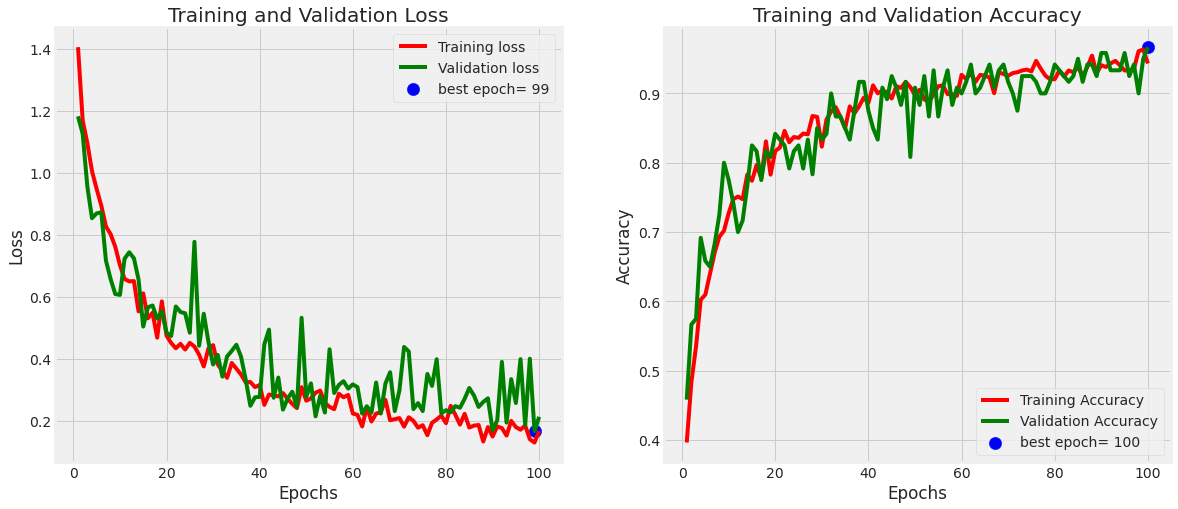

In [18]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Model Accuracy 

In [19]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

#b7 epoch 10
#.6875
#.679

#b5 epoch 10 
#.729
#.741

#v2 epoch 10
#.4375
#.481

#b3 epoch 10 
#.6875
#.666

#b3 epoch 10 w bs 24
#.763
#.679

#b3 epoch 10 sgd(.1)
#.83
#.71

#b3 epoch 1- sgd(.1) im_size = 256
#.83
#.80

##b3 epoch 1- sgd(.1) im_size = 300
#.88
#.80

##b3 same as above w drop_connect_rate = .3 (default .2)
#.77
#.64

##b3 same as above w drop_connect_rate = .3 (default .2) and no dropout layer in model
#.833
#.63

##b3 same as above w drop_connect_rate = .45 (default .2) and no dropout layer in model
#.84
#.69

###b3 same as above w drop_connect_rate = .45 (default .2) no model
#.58
#.60


##b3 same as above w drop_connect_rate = .55 (default .2) and no dropout layer in model
#.83
#.69


#same as above no regularizers
#.84
#.72

#same as above 100 epoch
#1.0
#.95

3/3 [==============================] - 6s 2s/step - loss: 0.1716 - accuracy: 0.9506
Train Loss:  0.026373883709311485
Train Accuracy:  1.0
--------------------
Test Loss:  0.1716010868549347
Test Accuracy:  0.9506173133850098


Getting the Prediction 

In [20]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)


/tmp/ipykernel_1932/1229029633.py:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



/tmp/ipykernel_1932/1419060858.py:10: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



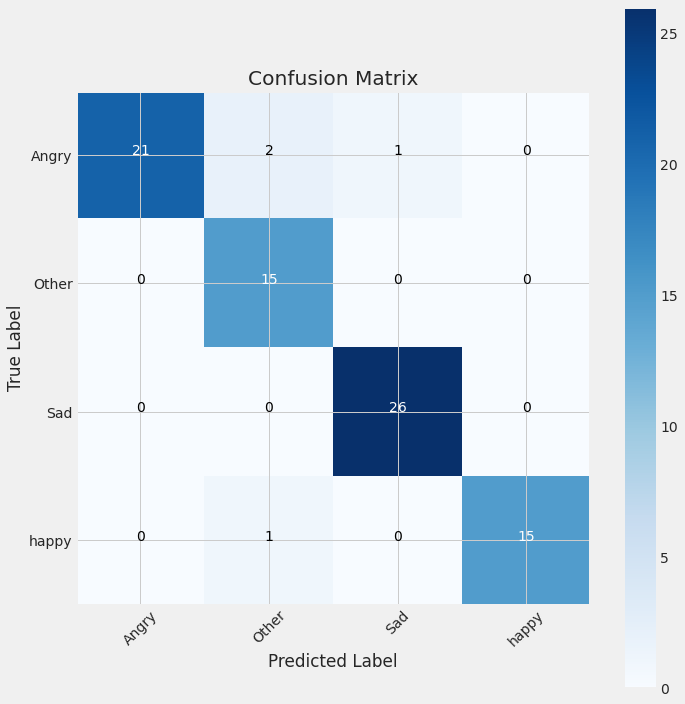

In [21]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Angry       1.00      0.88      0.93        24
       Other       0.83      1.00      0.91        15
         Sad       0.96      1.00      0.98        26
       happy       1.00      0.94      0.97        16

    accuracy                           0.95        81
   macro avg       0.95      0.95      0.95        81
weighted avg       0.96      0.95      0.95        81



In [23]:
#updated classifications
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Angry       1.00      0.88      0.93        24
       Other       0.83      1.00      0.91        15
         Sad       0.96      1.00      0.98        26
       happy       1.00      0.94      0.97        16

    accuracy                           0.95        81
   macro avg       0.95      0.95      0.95        81
weighted avg       0.96      0.95      0.95        81



Loading the Model and Predicting Inputs!

1/1 [==============================] - 0s 131ms/step


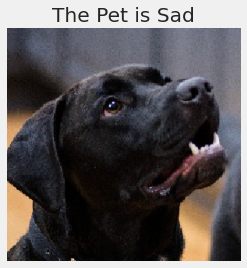

In [55]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model):
    
    img = image.load_img(image_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    if predicted_class_label == 'Other':
        plt.title(f"The pet is normal")
    else:
        plt.title(f"The Pet is {predicted_class_label}")
    plt.show()
    
#model.load_weights('/kaggle/working/Pets_Facial_Expression_model.h5')

class_labels = ['Angry', 'Other', 'Sad', 'Happy']

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = "pet_images/Sad/003.jpg"
predict_and_display(image_path_to_test, model)

In [56]:
model.save("95_model.h5")

/home/mattmori/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [58]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

model_test = load_model("95_model.h5")

In [60]:
model_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 11216563 (42.79 MB)
Trainable params: 4299

1/1 [==============================] - 2s 2s/step


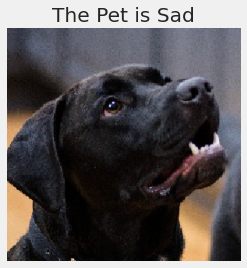

In [61]:

image_path_to_test = "pet_images/Sad/003.jpg"
predict_and_display(image_path_to_test, model_test)

In [62]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_test.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_test.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_test.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


3/3 [==============================] - 6s 2s/step - loss: 0.1623 - accuracy: 0.9753
Train Loss:  0.004944840911775827
Train Accuracy:  1.0
--------------------
Test Loss:  0.1622990220785141
Test Accuracy:  0.9753086566925049
